# Part 2: Depth from Rectified Stereo Images

## 1. Implementation and Results:

### 1.1 Implementation with Supporting Functions:

In [1]:
import pygco
import numpy as np
import cv2
from PIL import Image
from pylab import *
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
DIST_NUM = 45
mLambda = 10

In [2]:
# generate a number of disparities as labels
def setDisparities1(maxDist, distStep):
    dists = np.array(range(0, maxDist, distStep))
    return dists

In [3]:
# # generate a number of disparities as labels
# def setDisparities(imgWidth, nDist):
#     distStep = int(imgWidth/nDist)
#     dists = np.array(range(0, imgWidth, distStep))
#     for eachDist in dists:
#         if(eachDist!=0):
#             eachDist-=1
#     return dists

In [4]:
def getRgbDist(rgb1, rgb2):
    # get the L2 distance of the pixel value of two points
    if(rgb1[0] > rgb2[0]):      
        rDiff = rgb1[0] - rgb2[0]
    else:
        rDiff = rgb2[0] - rgb1[0]
    if(rgb1[1] > rgb2[1]):      
        gDiff = rgb1[1] - rgb2[1]
    else:
        gDiff = rgb2[1] - rgb1[1]
    if(rgb1[2] > rgb2[2]):      
        bDiff = rgb1[2] - rgb2[2]
    else:
        bDiff = rgb2[2] - rgb1[2]
#     print((rDiff/3 + gDiff/3 + bDiff/3))
    return ((rDiff/3 + gDiff/3 + bDiff/3))
        

In [5]:
def buildGraphFromImages(img1, img2, dists):
    imgHeight = img1.shape[0] # range of vertical rows
    imgWidth = img1.shape[1] # range of horizontal columns
    
    nDists= dists.shape[0]
    print(nDists)
    # get prior term matrix/ pairwiseCost:
    pairwiseCost = np.zeros((nDists, nDists))
    for i in range(0, nDists):
        for j in range(0, nDists):
#             pairwiseCost[i][j] = getDist(dists[i], dists[j])
            pairwiseCost[i][j] = abs(dists[i]-dists[j])
    print(pairwiseCost)
    # get data term: edges, edgeWeights, unaryCosts
    nNodes = imgHeight*imgWidth
    nEdges = (2*imgHeight*imgWidth-imgHeight-imgWidth)
    
    edges = np.zeros((nEdges, 2))
    edgeWeights = np.ones((nEdges))
    unaryCosts = np.ones((nNodes, nDists))*(255)
    print(unaryCosts)
    
    # r for row and c for column of a image
    edgeIndex = 0;
    for r in range(0, imgHeight):
        for c in range(0, imgWidth):
            # get edges and weights from current node to right next node and bottom next node:
            nodeNo = r*imgWidth+c
            rightNodeNo = nodeNo+1
            bottomNodeNo = nodeNo+imgWidth
            if(rightNodeNo < nNodes and c < imgWidth-1):
                edges[edgeIndex,:] = np.array([nodeNo, rightNodeNo])
                edgeIndex+=1
            if(bottomNodeNo < nNodes and r < imgHeight-1):
                edges[edgeIndex,:] = np.array([nodeNo, bottomNodeNo])
                edgeIndex+=1
            # get unary costs/ data term array:
            leftNodeRGB = img1[r][c]
            for i in range(0, nDists):
                dist = dists[i]
                if(int(c+dist) < imgWidth):
                    rightNodeRGB = img2[r][int(c+dist)]
                    unaryCosts[nodeNo,i] = getRgbDist(leftNodeRGB, rightNodeRGB)
                else:
                    break

    return edges, edgeWeights, unaryCosts, pairwiseCost

In [6]:
# # form an image from returned lables from graph cut:
# def formImg(orgImg, dists, labels):
#     imgHeight = orgImg.shape[0]
#     imgWidth = orgImg.shape[1]
#     output = np.zeros((imgHeight, imgWidth, 1))
#     grayScaleStep = 255/dists.shape[0]
#     for r in range(0, imgHeight):
#         for c in range(0, imgWidth):
#             label = labels[r*imgWidth+c]
#             output[r][c] = label*grayScaleStep
#     return output

In [7]:
# form an image from lables:
def formImg1(orgImg, dists, labels):
    imgHeight = orgImg.shape[0]
    imgWidth = orgImg.shape[1]
    output = np.zeros((imgHeight, imgWidth, 1))
    grayScaleStep = 255/dists.shape[0]
    print(grayScaleStep)
    for r in range(0, imgHeight):
        for c in range(0, imgWidth):
            label = labels[r*imgWidth+c]
#             print(label)
#             print(label*grayScaleStep)
            output[r][c] = (label*grayScaleStep)/255
    return output

In [8]:
leftImg = cv2.imread('im6.png')
leftImg = cv2.cvtColor(leftImg, cv2.COLOR_BGR2RGB)
rightImg = cv2.imread('im2.png')
rightImg = cv2.cvtColor(rightImg, cv2.COLOR_BGR2RGB)

### 1.2 Result 1: a Smoother Result with Less Details

In [9]:
MAX_DIST = 64
DIST_STEP = 1

In [10]:
dists = setDisparities1(MAX_DIST, DIST_STEP)
print(dists)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]


64
[[ 0.  1.  2. ... 61. 62. 63.]
 [ 1.  0.  1. ... 60. 61. 62.]
 [ 2.  1.  0. ... 59. 60. 61.]
 ...
 [61. 60. 59. ...  0.  1.  2.]
 [62. 61. 60. ...  1.  0.  1.]
 [63. 62. 61. ...  2.  1.  0.]]
[[255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 ...
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]]
3.984375


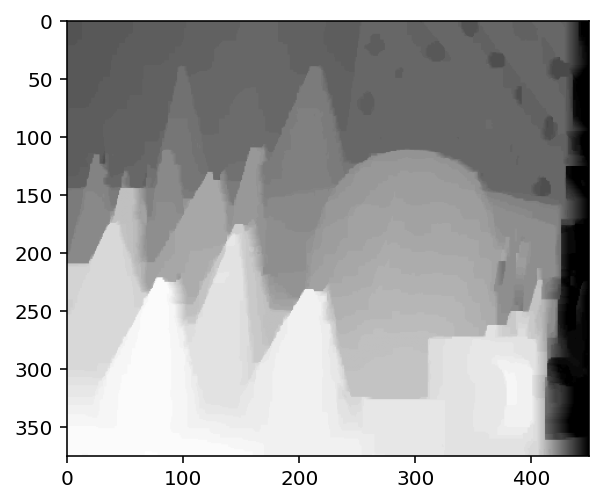

[17 17 17 ...  2  1  0]


In [11]:
mLambda = 10
edges, edgeWeights, unaryCosts, pairwiseCost  = buildGraphFromImages(leftImg, rightImg, dists)
labels = pygco.cut_general_graph(edges, mLambda*edgeWeights, unaryCosts, pairwiseCost)
output = formImg1(leftImg, dists, labels)
plt.imshow(output/255, cmap = "gray")
plt.show()
print(labels)

### 1.3 Results 2: A Noisier but More Detailed Result：

64
[[ 0.  1.  2. ... 61. 62. 63.]
 [ 1.  0.  1. ... 60. 61. 62.]
 [ 2.  1.  0. ... 59. 60. 61.]
 ...
 [61. 60. 59. ...  0.  1.  2.]
 [62. 61. 60. ...  1.  0.  1.]
 [63. 62. 61. ...  2.  1.  0.]]
[[255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 ...
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]]
3.984375


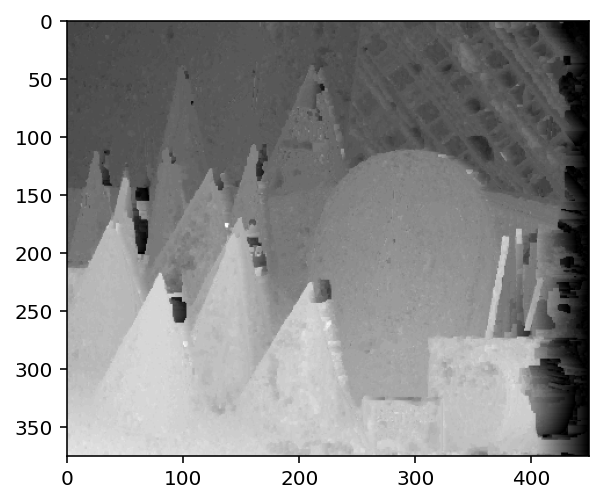

[18 17 17 ...  0  1  0]


In [12]:
edges, edgeWeights, unaryCosts, pairwiseCost  = buildGraphFromImages(leftImg, rightImg, dists)
labels = pygco.cut_general_graph(edges, edgeWeights, unaryCosts, pairwiseCost)
output = formImg1(leftImg, dists, labels)
plt.imshow(output/255, cmap = "gray")
plt.show()
print(labels)

## 2. Discussion

In this project, Lambda or $\lambda$ is an integer larger than 1. It is a gain for the edgeweight parameter. For this part, the original edgeweights is an all-zero matrix, denoting that every edge of the graph to cut has a weight of value 1.   
From the result of the experiement, the values of Lambda can affect the results. A smaller Lambda gives a more detailed but noisier result while a bigger Lambda gives a smoother but less detailed result. The author showed two results because it is hard to decide which one is better, since both the results provides reliable information of the depth of objects, and the definition of a "better" result may vary from one application to another.   
The reason that Lambda is affecting the result might have something to do with the globlization of graph cut. When doing graph cut, one let "flow" to spread amoung the graph through "pipes" or edges, to achieve gloablization. If the pipes or edges are too thin compared to the amount of water from the source (unary cost), very few water can spread amoung the nodes through the thin pipes and very much water will directly go to the sink. In that case, the graph cut might produce a result that is not very "global optimized". Thus, some noisy dots appears on the result of such settings with a low edge value compared to the unary cost. By increasing the value of Lambda, we are employing a wider pipe, allowing more flows to be directed from one source to sinks far away from that source, thus, the result will be more global optimized and showing less noise.  
Following this analysis, one can also see that a better global optimization is achievable if the parameters, such as edge weights, unary costs or any thresholds set in the program are balanced, or say, their values are not with a huge difference. 